In [1]:
!nvidia-smi

Sun Nov  6 10:42:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    18W /  N/A |    246MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from pathlib import Path

data_dir = Path('/app/notebooks/image_stitching/sample_data/keyboard')
assert data_dir.exists()

In [3]:
device = torch.device('cpu')

In [4]:
available_exts = ['.jpg', '.png']

def load_dir(dir_path):
    dir_path = Path(dir_path)
    
    imgs = []
    for file_path in dir_path.iterdir():
        if file_path.suffix not in available_exts:
            continue
        
        i_img = Image.open(file_path)
        i_timg = kornia.utils.image_to_tensor(np.array(i_img), False).float() / 255.
        i_timg = i_timg.to(device)
        imgs.append(i_timg)
        
    timg = torch.cat(imgs, dim=0)
    timg_gray = kornia.color.rgb_to_grayscale(timg)
    return timg, timg_gray

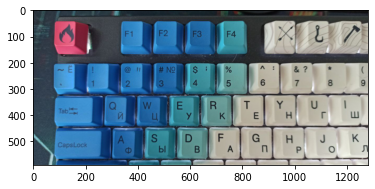

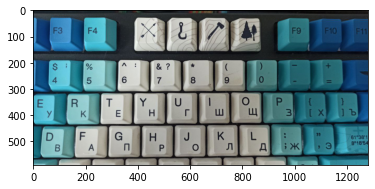

In [5]:
timg, timg_gray = load_dir(data_dir)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

In [6]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

In [112]:
PS = 41

sift = kornia.feature.TFeat(True).to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)

descriptor = sift

resp = BlobDoG()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              scale_space_response=True,#We need that, because DoG operates on scale-space
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(32, 
                                                                    angle_detector=kornia.feature.OriNet(True)),
                              mr_size=6.0,
                              minima_are_also_good=True).to(device) #dark blobs are as good as bright.

def get_features(src_img, target_img):
    img_pair = torch.cat([src_img, target_img], dim=0)

    with torch.no_grad():
        lafs, resps = detector(img_pair)
        patches =  kornia.feature.extract_patches_from_pyramid(img_pair, lafs, PS)
        B, N, CH, H, W = patches.size()
        # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
        # So we need to reshape a bit :) 
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs

def get_matches(src_descs, target_desc):
    matches_arr = []
    for i_descs in src_descs:
        scores, matches = kornia.feature.match_snn(i_descs, descs[-1], 0.9)
        matches_arr.append(matches)
    
    return matches_arr
        
# Difference-of-Gaussians + OriNet + TFeat
def get_keypoints(src_img, target_img):
    lafs, descs = get_features(src_img, target_img)
    matches = get_matches(descs[:-1], descs[-1])
    
    src_b_size = src_img.shape[0]
    idxs = list(range(src_b_size))# should be src img batch size

    pts = []
    for i, i_matches in zip(idxs, matches):
        src_pts = lafs[i,i_matches[:,0], :, 2].data.cpu().numpy()
        dst_pts = lafs[src_b_size,i_matches[:,1], :, 2].data.cpu().numpy()
        pts.append((src_pts, dst_pts))
    
    return pts

def merge_imgs(src_img, src_pts, dst_img, dst_pts):
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)
    
    nimg1 = src_img.cpu()[0].permute(1,2,0).numpy()
    nimg2 = dst_img.cpu()[0].permute(1,2,0).numpy()

    width = nimg1.shape[1] + nimg2.shape[1] + 200
    print("width ", width) 

    height = max(nimg1.shape[0], nimg2.shape[0]) + 200

    result = cv2.warpPerspective(nimg1, H,  (width, height))

    # # # The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my query_photo

    result[0:nimg2.shape[0], 0:nimg2.shape[1]] = nimg2
    return result

In [136]:
idx = 2

In [137]:
timg_src_gray = timg_gray[idx:idx+1]
timg_dst_gray = timg_gray[idx-1:idx]

pts = get_keypoints(timg_src_gray, timg_dst_gray)

In [139]:
timg_src = timg[idx:idx+1]
timg_dst = timg[idx-1:idx]

resut_img = merge_imgs(timg_src, pts[0][0], timg_dst, pts[0][1])

width  2760


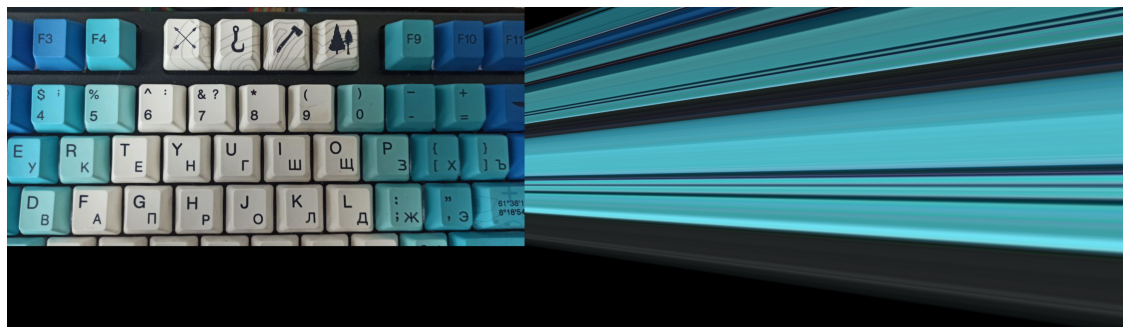

In [140]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(resut_img)